In [3]:
import pandas as pd
import numpy as np
import random
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import os

import cv2

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

from ipywidgets import widgets, VBox, HBox

from IPython.display import display, clear_output

from PIL import Image, ImageDraw, ImageFont

import base64
from io import BytesIO

from tqdm import tqdm

# Finding Valid Training Data

In [2]:
train_labels = pd.read_csv('../../../data/Patch Perfect Data/train_labels.csv')
train_labels.columns = ['pothole_id', 'bags_used']
train_labels['pothole_id'] = 'p'+train_labels['pothole_id'].astype(str)

test_labels = pd.read_csv('../../../data/Patch Perfect Data/test_labels.csv')
test_labels.columns = ['pothole_id', 'bags_used']
test_labels['pothole_id'] = 'p'+test_labels['pothole_id'].astype(str)

In [ ]:
train_images_path = '../../../data/Patch Perfect Data/train_images'

In [ ]:
train_image_files = [f for f in os.listdir(train_images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
train_image_ids = [os.path.splitext(f)[0] for f in train_image_files]
valid_ids = train_labels[train_labels['pothole_id'].isin(train_image_ids)]
valid_ids = valid_ids.reset_index(drop=True)
print(valid_ids.head(30))

In [ ]:
valid_ids.to_csv('data/valid_ids.csv', index=False)

# Compute Area of Pothole

### Models

In [4]:
pothole_id_model = YOLO('../../V2/data/1 Pothole ID model/models/best.pt')
l1_model = YOLO('../../V2/data/2 L1 ID model/models/best.pt')
segmentation_model = YOLO('YOLO/Segmentation/best.pt')

### Auxiliary Functions

In [6]:
def find_red_centroids_in_bbox(image, bbox):
    x1, y1, x2, y2 = bbox
    cropped_image = image[y1:y2, x1:x2]

    hsv_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv_cropped, lower_red, upper_red)

    lower_red = np.array([160, 100, 100])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv_cropped, lower_red, upper_red)

    mask = mask1 + mask2

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    height, width = cropped_image.shape[:2]
    half_width = width // 2
    half_height = height // 2

    left_half_centroids = []
    right_half_centroids = []
    top_half_centroids = []
    bottom_half_centroids = []

    for contour in contours:
        area = cv2.contourArea(contour)
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00'])
            cY = int(M['m01'] / M['m00'])
            
            if height > width:  # Vertical orientation
                if cY < half_height:
                    top_half_centroids.append((cX + x1, cY + y1, area))
                else:
                    bottom_half_centroids.append((cX + x1, cY + y1, area))
            else:  # Horizontal orientation
                if cX < half_width:
                    left_half_centroids.append((cX + x1, cY + y1, area))
                else:
                    right_half_centroids.append((cX + x1, cY + y1, area))

    def select_largest_area(centroids):
        if not centroids:
            return None
        return max(centroids, key=lambda x: x[2])

    if height > width:  # Vertical orientation
        top_centroid = select_largest_area(top_half_centroids)
        bottom_centroid = select_largest_area(bottom_half_centroids)

        if not top_centroid:
            top_centroid = (x1 + width // 2, y1 + int(height * 0.1))

        if not bottom_centroid:
            bottom_centroid = (x1 + width // 2, y2 - int(height * 0.1))

        return [top_centroid, bottom_centroid]
    else:  # Horizontal orientation
        left_centroid = select_largest_area(left_half_centroids)
        right_centroid = select_largest_area(right_half_centroids)

        if not left_centroid:
            left_centroid = (x1 + int(width * 0.1), y1 + height // 2)

        if not right_centroid:
            right_centroid = (x2 - int(width * 0.1), y1 + height // 2)

        return [left_centroid, right_centroid]

def compute_area(image_path, pothole_id_model, l1_model, segmentation_model):
    # Load the image
    image = cv2.imread(image_path)

    # Step 1: Detect the L1 bounding box using the model
    l1_results = l1_model.predict(source=image, save=False, verbose=False)

    if len(l1_results[0].boxes) > 0:
        # Get the bounding box with the highest confidence
        l1_boxes = l1_results[0].boxes.xyxy.cpu().numpy()
        l1_confidences = l1_results[0].boxes.conf.cpu().numpy()
        l1_max_conf_idx = np.argmax(l1_confidences)
        l1_bbox = l1_boxes[l1_max_conf_idx].astype(int)

        # Step 2: Find the red centroids in the L1 bounding box
        red_centroids = find_red_centroids_in_bbox(image, l1_bbox)
        return red_centroids
    else:
        return None

## Main Function

In [7]:
def compute_area(image_path, pothole_id_model, l1_model, segmentation_model, plot_progress=False):
    # Load the image
    image = cv2.imread(image_path)

    # Step 1: Detect the L1 bounding box using the model
    l1_results = l1_model.predict(source=image, save=False, verbose=False, conf=0.001)

    if len(l1_results[0].boxes) > 0:
        # Get the bounding box with the highest confidence
        l1_boxes = l1_results[0].boxes.xyxy.cpu().numpy()
        l1_confidences = l1_results[0].boxes.conf.cpu().numpy()
        l1_max_conf_idx = np.argmax(l1_confidences)
        l1_bbox = l1_boxes[l1_max_conf_idx].astype(int)

        # Step 2: Find the red centroids in the L1 bounding box
        red_centroids = find_red_centroids_in_bbox(image, l1_bbox)
        if red_centroids is None:
            print("No red centroids found.")
            return None, None, None, None
        
        # Step 3: Calculate the pixel-to-mm ratio
        if len(red_centroids) == 2:
            pixel_distance = np.linalg.norm(np.array(red_centroids[0][:2]) - np.array(red_centroids[1][:2]))
            mm_to_pixel_ratio = 500 / pixel_distance if pixel_distance > 0 else None
        else:
            print("Insufficient red centroids found.")
            return None, None, None, None
        
        # Step 4: Detect the pothole bounding box using the pothole model
        pothole_results = pothole_id_model.predict(source=image, save=False, verbose=False, conf=0.001)

        if len(pothole_results[0].boxes) > 0:
            # Get the bounding box with the highest confidence
            pothole_boxes = pothole_results[0].boxes.xyxy.cpu().numpy()
            pothole_confidences = pothole_results[0].boxes.conf.cpu().numpy()
            pothole_max_conf_idx = np.argmax(pothole_confidences)
            pothole_bbox = pothole_boxes[pothole_max_conf_idx].astype(int)

            # Calculate the length and width of the pothole bounding box in pixels
            pothole_length = pothole_bbox[2] - pothole_bbox[0]
            pothole_width = pothole_bbox[3] - pothole_bbox[1]

            # Step 5: Predict the pothole contour using the segmentation model on the entire image
            contour_results = segmentation_model.predict(source=image, conf=0.001, save=False, verbose=False)

            pothole_area_pixels = 0
            if contour_results[0].masks is not None:
                masks = contour_results[0].masks.data.cpu().numpy()
                mask_scores = contour_results[0].boxes.conf.cpu().numpy()
                max_conf_idx = np.argmax(mask_scores)
                best_mask = masks[max_conf_idx]

                # Apply threshold to mask
                mask = (best_mask > 0.5).astype(np.uint8) * 255

                # Resize mask to fit original image scale
                mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))

                # Find contours in the mask
                contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Calculate the area of the contour
                for contour in contours:
                    pothole_area_pixels += cv2.contourArea(contour)

                # Draw contours on the original image
                cv2.drawContours(image, contours, -1, (0, 255, 0), 2)  # Green contours

            if plot_progress:
                # Plot the L1 bounding box, pothole bounding box, red points, and contour
                cv2.rectangle(image, (l1_bbox[0], l1_bbox[1]), (l1_bbox[2], l1_bbox[3]), (255, 0, 0), 2)  # L1 box in blue
                cv2.rectangle(image, (pothole_bbox[0], pothole_bbox[1]), (pothole_bbox[2], pothole_bbox[3]), (0, 255, 255), 2)  # Pothole box in yellow

                for point in red_centroids:
                    if point:
                        cv2.circle(image, point[:2], 5, (0, 0, 255), -1)  # Red dots

                # Convert to RGB for displaying
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Display the image
                plt.figure(figsize=(10, 10))
                plt.imshow(image_rgb)
                plt.axis('off')
                plt.show()

            # Calculate the area in square millimeters
            pothole_area_mm2 = pothole_area_pixels * (mm_to_pixel_ratio ** 2) if mm_to_pixel_ratio else None

            return mm_to_pixel_ratio, pothole_length, pothole_width, pothole_area_mm2
        else:
            print("No pothole detected in the image.")
            return None, None, None, None
    else:
        print("No L1 bounding box detected.")
        return None, None, None, None

# Creating DataFrames

In [ ]:
train_images_dir = '../../../data/Patch Perfect Data/train_images'
test_images_dir = '../../../data/Patch Perfect Data/test_images'

# Assuming valid_ids is already defined as a list of valid pothole_ids
train_data = []
test_data = []
test_none_data = []

# Process train images
for image_name in os.listdir(train_images_dir):
    pothole_id = os.path.splitext(image_name)[0]
    
    if pothole_id in valid_ids['pothole_id'].values:
        image_path = os.path.join(train_images_dir, image_name)
        mm_to_pixel_ratio, length, width, area_mm2 = compute_area(image_path, pothole_id_model, l1_model, segmentation_model, plot_progress=False)
        
        # Only add to train_data if none of the values are None
        if None not in [mm_to_pixel_ratio, length, width, area_mm2]:
            train_data.append({
                'pothole_id': pothole_id,
                'mm_to_pixel_ratio': mm_to_pixel_ratio,
                'pothole_length': length,
                'pothole_width': width,
                'pothole_area_mm2': area_mm2
            })

train_df = pd.DataFrame(train_data)
print("Train DataFrame created successfully.")

In [ ]:
train_df.shape

In [ ]:
# Process test images
for image_name in os.listdir(test_images_dir):
    pothole_id = os.path.splitext(image_name)[0]
    
    image_path = os.path.join(test_images_dir, image_name)
    mm_to_pixel_ratio, length, width, area_mm2 = compute_area(image_path, pothole_id_model, l1_model, segmentation_model, plot_progress=False)
    
    if mm_to_pixel_ratio is not None:
        test_data.append({
            'pothole_id': pothole_id,
            'mm_to_pixel_ratio': mm_to_pixel_ratio,
            'pothole_length': length,
            'pothole_width': width,
            'pothole_area_mm2': area_mm2
        })
    else:
        test_none_data.append({
            'pothole_id': pothole_id,
            'mm_to_pixel_ratio': None,
            'pothole_length': None,
            'pothole_width': None,
            'pothole_area_mm2': None
        })

test_df = pd.DataFrame(test_data)
test_none_df = pd.DataFrame(test_none_data)

print("Test DataFrame created successfully.")
if not test_none_df.empty:
    print("Some test images returned None values. These have been stored in test_none_df.")

In [ ]:
train_df.shape

In [ ]:
test_df.shape

In [ ]:
train_df = train_df.merge(train_labels[['pothole_id', 'bags_used']], on='pothole_id', how='left')

In [ ]:
train_df.head()

In [ ]:
train_df.to_csv('data/train_df.csv', index=False)dd
test_df.to_csv('data/test_df.csv', index=False)

In [ ]:
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

In [ ]:
new = pd.read_csv('../../V2/Combined Data/train_labels.csv')

In [ ]:
new[new['Bags used ']>=10]

In [ ]:
new['Bags used '].value_counts().sort_index()

In [ ]:
train_df['bags_used'].value_counts().sort_index()

# Multimodel Learning

### Extract Pothole Contours

In [ ]:
def extract_pothole_contours(image_dir, df, segmentation_model, output_dir):
    """
    Extracts and saves the highest probable pothole contour from images using a segmentation model.
    
    Parameters:
    - image_dir: Directory where images are stored.
    - df: DataFrame containing pothole IDs.
    - segmentation_model: Pre-trained segmentation model to detect potholes.
    - output_dir: Directory to save the extracted pothole contour images.
    
    Returns:
    - A new DataFrame with pothole IDs and paths to the extracted contours.
    """
    os.makedirs(output_dir, exist_ok=True)
    contour_data = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        pothole_id = row['pothole_id']
        image_path = os.path.join(image_dir, f'{pothole_id}.jpg')
        image = cv2.imread(image_path)
        
        if image is None:
            continue
        
        # Step 2: Use the segmentation model to get the pothole mask
        contour_results = segmentation_model.predict(source=image, conf=0.01, save=False, verbose=False)
        
        if contour_results[0].masks is None:
            continue
        
        # Keep only the contour with the highest probability
        masks = contour_results[0].masks.data.cpu().numpy()
        mask_scores = contour_results[0].boxes.conf.cpu().numpy()
        max_conf_idx = np.argmax(mask_scores)
        
        best_mask = masks[max_conf_idx]
        contour = (best_mask > 0.5).astype(np.uint8) * 255
        contour = cv2.resize(contour, (image.shape[1], image.shape[0]))

        # Save the contour image
        contour_image_name = f"{pothole_id}_contour_best.jpg"
        contour_image_path = os.path.join(output_dir, contour_image_name)
        cv2.imwrite(contour_image_path, contour)

        # Add to the list of data to be included in the new DataFrame
        contour_data.append({
            'pothole_id': pothole_id,
            'contour_image_path': contour_image_path
        })

    # Create a new DataFrame with the contour data
    contour_df = pd.DataFrame(contour_data)
    return contour_df

# Example usage:
train_image_dir = '../../../data/Patch Perfect Data/train_images'
test_image_dir = '../../../data/Patch Perfect Data/test_images'
train_output_dir = 'YOLO/Segmentation/extracted_contours/train'
test_output_dir = 'YOLO/Segmentation/extracted_contours/test'

train_contour_df = extract_pothole_contours(train_image_dir, train_df, segmentation_model, train_output_dir)
test_contour_df = extract_pothole_contours(test_image_dir, test_df, segmentation_model, test_output_dir)

# Save the new DataFrames with contour image paths
train_contour_df.to_csv('YOLO/Segmentation/extracted_contours/train_contour_df.csv', index=False)
test_contour_df.to_csv('YOLO/Segmentation/extracted_contours/test_contour_df.csv', index=False)

### Training Model

In [ ]:
class PotholeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['contour_image_path']).convert('RGB')
        scalar_features = torch.tensor([
            row['pothole_area_mm2'], 
            row['pothole_length'], 
            row['pothole_width'], 
            row['mm_to_pixel_ratio']
        ], dtype=torch.float32)
        bags_used = torch.tensor(row['bags_used'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, scalar_features, bags_used

# Image transformations for data augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load data
train_contour_df = pd.read_csv('YOLO/Segmentation/extracted_contours/train_contour_df.csv')
train_df = train_df.merge(train_contour_df, on='pothole_id')

test_contour_df = pd.read_csv('YOLO/Segmentation/extracted_contours/test_contour_df.csv')
test_df = test_df.merge(test_contour_df, on='pothole_id')

# Create datasets and dataloaders
train_dataset = PotholeDataset(train_df, transform=transform)
test_dataset = PotholeDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class MultimodalPotholeModel(nn.Module):
    def __init__(self):
        super(MultimodalPotholeModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer
        
        self.fc1 = nn.Linear(512 + 4, 128)  # 512 from ResNet + 4 scalar features
        self.fc2 = nn.Linear(128, 1)

    def forward(self, images, scalar_features):
        cnn_out = self.resnet(images)
        combined = torch.cat((cnn_out, scalar_features), dim=1)
        output = self.fc1(combined)
        output = self.fc2(output)
        return output

# Initialize model, loss, and optimizer
model = MultimodalPotholeModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, scalar_features, bags_used in train_loader:
        images, scalar_features, bags_used = images.to(device), scalar_features.to(device), bags_used.to(device)

        optimizer.zero_grad()
        outputs = model(images, scalar_features).squeeze()
        loss = criterion(outputs, bags_used)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Evaluation loop
model.eval()
with torch.no_grad():
    running_loss = 0.0
    for images, scalar_features, bags_used in test_loader:
        images, scalar_features, bags_used = images.to(device), scalar_features.to(device)
        outputs = model(images, scalar_features).squeeze()
        loss = criterion(outputs, bags_used)
        running_loss += loss.item() * images.size(0)

    test_loss = running_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

In [ ]:
torch.save(model.state_dict(), 'multimodal_prediction_model/multimodal_pothole_model.pth')

### Imputing Observation pothole_area=0

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def impute_pothole_area(df, features, target='pothole_area_mm2'):
    # Separate rows with pothole_area_mm2 == 0 and pothole_area_mm2 > 0
    zero_area_df = df[df[target] == 0]
    non_zero_area_df = df[df[target] > 0]

    # Separate features and target for non-zero area observations
    X = non_zero_area_df[features]
    y = non_zero_area_df[target]

    # Train a regression model (e.g., RandomForest)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict the pothole_area_mm2 for observations with zero area
    if not zero_area_df.empty:
        X_zero_area = zero_area_df[features]
        predicted_areas = model.predict(X_zero_area)

        # Impute the predicted values into the original DataFrame
        df.loc[df[target] == 0, target] = predicted_areas

    return df

In [ ]:
train_features = ['mm_to_pixel_ratio', 'pothole_length', 'pothole_width', 'bags_used']
train_df_imputed = impute_pothole_area(train_df, train_features)

In [ ]:
test_features = ['mm_to_pixel_ratio', 'pothole_length', 'pothole_width']
test_df_imputed = impute_pothole_area(test_df, test_features)

In [ ]:
cor = train_df_imputed.drop('pothole_id', axis=1).corr()

In [ ]:
cor['bags_used']

In [ ]:
sns.heatmap(cor)

# Regression

In [ ]:
plt.scatter(train_df['pothole_area_mm2'], train_df['bags_used'])

## Training Model

### Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler

In [ ]:
features = ['mm_to_pixel_ratio', 'pothole_length', 'pothole_width', 'pothole_area_mm2']
#features = ['mm_to_pixel_ratio', 'pothole_area_mm2']
#X = train_df_imputed[features]
#y = train_df_imputed['bags_used']

X = train_df_combined.drop(['bags_used', 'pothole_id'], axis=1)
y = train_df_combined['bags_used']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_val)

In [ ]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
final_model = RandomForestRegressor(n_estimators=40, random_state=42)
final_model.fit(X, y)

In [ ]:
test_features = ['mm_to_pixel_ratio', 'pothole_length', 'pothole_width', 'pothole_area_mm2']
predicted_bags_used = final_model.predict(test_df[test_features])

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
X = train_df_imputed[features]
y = train_df_imputed['bags_used']

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data into DMatrix format required by XGBoost
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
val_dmatrix = xgb.DMatrix(X_val, label=y_val)

# Define the parameters for XGBoost
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

# Train the model
xgb_model = xgb.train(params, train_dmatrix, num_boost_round=100, evals=[(val_dmatrix, "validation")], early_stopping_rounds=10)

In [ ]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

In [ ]:
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
features = ['mm_to_pixel_ratio', 'pothole_length', 'pothole_width', 'pothole_area_mm2']
#features = ['pothole_area_mm2']
X = train_df_imputed[features]
y = train_df_imputed['bags_used']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

In [ ]:
y_pred = model.predict(X_val_scaled)

#### Cross Validation to estimate test error

In [ ]:
features = ['mm_to_pixel_ratio', 'pothole_length', 'pothole_width', 'pothole_area_mm2']
#features = ['pothole_area_mm2']
#features = ['pothole_length', 'pothole_width']
X = train_df_imputed[features]
y = train_df_imputed['bags_used']

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scorer(r2_score)

In [ ]:
linear_model = LinearRegression()

# Perform cross-validation
linear_cv_scores = cross_val_score(linear_model, X, y, cv=kf, scoring=scoring)

# Calculate mean and standard deviation of the R² scores
linear_mean_r2 = np.mean(linear_cv_scores)
linear_std_r2 = np.std(linear_cv_scores)

print(f"Linear Regression - Mean CV R²: {linear_mean_r2:.4f}, Std: {linear_std_r2:.4f}")

#### Training on full dataset

In [ ]:
model = LinearRegression()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(test_df[features])

In [ ]:
model.fit(X_scaled, y)

In [ ]:
predicted_bags_used = model.predict(X_test_scaled)

### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
features = ['mm_to_pixel_ratio', 'pothole_length', 'pothole_width', 'pothole_area_mm2']
#features = ['pothole_area_mm2']
X = train_df_imputed[features]
y = train_df_imputed['bags_used']

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
ridge_model = Ridge(alpha=2)  # You can adjust alpha to tune regularization

# Fit the model to the training data
ridge_model.fit(X_train, y_train)

In [ ]:
y_pred = ridge_model.predict(X_val)

# Calculate Mean Squared Error and R-squared
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

#### Cross Validation

In [ ]:
ridge_model = Ridge(alpha=5.0)  # You can adjust alpha based on prior tuning

# Perform cross-validation
ridge_cv_scores = cross_val_score(ridge_model, X, y, cv=kf, scoring=scoring)

# Calculate mean and standard deviation of the R² scores
ridge_mean_r2 = np.mean(ridge_cv_scores)
ridge_std_r2 = np.std(ridge_cv_scores)

print(f"Ridge Regression - Mean CV R²: {ridge_mean_r2:.4f}, Std: {ridge_std_r2:.4f}")

In [ ]:
model = Ridge(alpha=5.0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(test_df[features])

In [ ]:
model.fit(X_scaled, y)

In [ ]:
predicted_bags_used = model.predict(X_test_scaled)

### Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
features = ['mm_to_pixel_ratio', 'pothole_length', 'pothole_width', 'pothole_area_mm2']
X = train_df_imputed[features]
y = train_df_imputed['bags_used']

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scorer(r2_score)

In [ ]:
lasso_model = Lasso(alpha=20)  # You can adjust alpha based on prior tuning

# Perform cross-validation
lasso_cv_scores = cross_val_score(lasso_model, X, y, cv=kf, scoring=scoring)

# Calculate mean and standard deviation of the R² scores
lasso_mean_r2 = np.mean(lasso_cv_scores)
lasso_std_r2 = np.std(lasso_cv_scores)

print(f"Lasso Regression - Mean CV R²: {lasso_mean_r2:.4f}, Std: {lasso_std_r2:.4f}")

### Prediction Matrix

In [ ]:
pred_df = pd.DataFrame({
    'Pothole number': test_df['pothole_id'],
    'Bags used ': predicted_bags_used
})

# Display the first few rows of pred_df
pred_df.head(10)

In [ ]:
round(test_df.head(10),3)

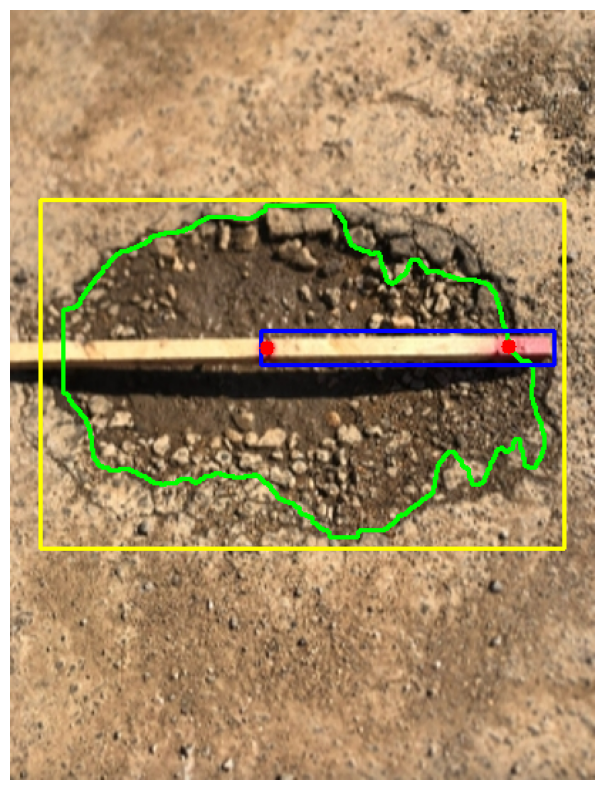

(2.9411255865026873, 368, 245, 463470.12214110245)

In [9]:
compute_area('../../V2/Combined Data/train_images/p64.jpg', pothole_id_model, l1_model, segmentation_model, plot_progress=True)

In [ ]:
pred_df['Pothole number'] = pred_df['Pothole number'].str.replace("p","").astype(int)
pred_df = pred_df.sort_values('Pothole number')

In [ ]:
pred_df.head(30)

In [ ]:
pred_df.set_index('Pothole number', inplace=True)

In [ ]:
pred_df.to_csv('../../../data/predictions/Ridge3.csv')